In [24]:
import numpy as np
import networkx as nx
import random
import matplotlib.pyplot as plt
import time
from numpy.random import uniform

In [3]:
#N is number of nodes, k is number of closest neighbours and p is probability that we change edge in single step
def Watatz(N=20, k=4, p=1):
    if(k%2==1):
        raise ValueError ("Need even number of closest neighbours!")
    
    #creates starting graph//do not move
    G = nx.Graph()
    G.add_nodes_from([i for i in range(N)])
    for i in G.nodes:
        for ki in range(int(k/2)):
            G.add_edges_from([((i+N-1-ki)%N,i), ((i+N+1+ki)%N,i)]) #calculations so N-1 is connected with 0
    
    #changes link for each
    new_G = nx.Graph()
    new_G.add_nodes_from(list(G.nodes))
    iterator = 0

    for link in G.edges:
        #relinking
        if(random.random()<p): #if we succeed in relinking
            new_link = link #for now it is as before
            if(random.random()<0.5): #whether relink node 1 or 2 from edge
                #we do not want link that already was in network, not that we have in currently created one
                while(new_link in list(G.edges)[iterator:] or new_link in new_G.edges):
                    for_choice = list(G.nodes)
                    for_choice.remove(new_link[0])
                    relink = random.choice(for_choice)
                    new_link = (new_link[0], relink)
                new_G.add_edge(new_link[0], new_link[1])
            else: #same procedure, but we change second end of edge
                while(new_link in list(G.edges)[iterator:] or new_link in new_G.edges):
                    for_choice = list(G.nodes)
                    for_choice.remove(new_link[1])
                    relink = random.choice(for_choice)
                    new_link = (relink, new_link[1])
                new_G.add_edge(new_link[0], new_link[1])
        else: #we simply add link that existed in starting network
            new_G.add_edge(link[0], link[1])
        iterator = iterator+1
        
    #new_G.add_nodes_from(list(G.nodes)) #in case some node got totally unconnected
    
    return new_G

''' we start with m0 nodes and in each step we add node connected to m<m0 previous nodes until we reach N nodes
    after t steps we should have N=m0+t nodes and E=m0+mt edges
'''
def Barabasi(m0, m, t):
    '''creating, start from 1 to be similar with previous ones
        we want to start with m0 nodes, m0 edges and each link connected,
        so I just start with triangle, then add new linked nodes'''
    
    G = nx.Graph()
    G.add_edges_from([(0,1), (0,2), (1,2)])
    for i in range(2,m0): 
        G.add_edge(i, random.choice(list(G.nodes)))
        
    #now we add new nodes, choose m distinct edges coming from new node
    for tau in range(t):
        pi = [nx.degree(G, nody)/(sum([nx.degree(G, n) for n in G.nodes])) for nody in G.nodes] #probability for each node
        choice_list =  np.random.choice(list(G.nodes), m, p=pi, replace=False) #choose randomly with no repetinions
        
        for link in choice_list:
            G.add_edge(link, tau+m0)
         #in case we do not link it to any node
      
    return G

## q-voter

In [ ]:
#for 3 dot only save results, plots are for 4th and 5th
#for 4th dot choose some values of p, between 0.1 and 0.6, 5 values of p

In [15]:
G_b = nx.barabasi_albert_graph(100, 4)

In [20]:
G_test = nx.barabasi_albert_graph(30, 4)

If we have less than q neigbours, just skip it

In [73]:
def q_voter(G, q=4, p=0.5, MC_step = 10, time_horizon=10):
    nodes = list(G.nodes())
    G_size = len(nodes)
    opinion_array = 2*np.random.randint(0,2,G_size)-1 #creates array full of either 1 or -1
    current_time = 0
    mean_opinion = [np.mean(opinion_array)]
    time_gone = [current_time]
    while(current_time < time_horizon):
        for _ in range(MC_step):
            current_node = np.random.choice(nodes)
            if(random.random()>p): 
                try:
                    list_of_neighbours = np.random.choice(list(G.neighbors(current_node)),size=q)
                except: #not enough neigbours to force change of our decision
                    break
                if(abs(np.mean(opinion_array[list_of_neighbours])==1)): #either all are -1 or 1 
                    opinion_array[current_node] = opinion_array[list_of_neighbours[0]] #all have the same state
                    
                #elif(random.random()<eps):
                #    print("niezgodni")
                #    opinion_array[current_node]*=-1

                opinion_array[current_node] =np.random.choice([-1,1]) #either changes or not their opinion
        current_time+=1
        mean_opinion.append(np.mean(opinion_array))
        time_gone.append(current_time)
    return mean_opinion, time_gone

In [67]:
q_voter(G_b,4,0.5,10,10)

[0.04, 0.02, -0.02, -0.04, 0.02, -0.02, -0.02, 0.0, 0.04, 0.08, 0.06]

In [70]:
q_voter(Barabasi(4,4,96),4,0.5,10,10)

[-0.06, -0.1, -0.14, -0.12, -0.12, -0.12, -0.14, -0.12, -0.08, -0.06, -0.06]

# 1st dot

# 2nd dot

# 3rd dot

# 4th dot

In [72]:
G_w = nx.watts_strogatz_graph(100, 4, 0.01)

In [83]:
m_ops, t_gone = q_voter(G_w,q=4,p=0.1,MC_step=1,time_horizon=1000)
m_ops2, t_gone2 = q_voter(G_w,q=4,p=0.1,MC_step=1,time_horizon=1000)

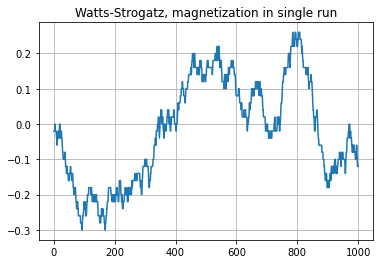

In [82]:
plt.plot(t_gone, m_ops)
plt.title('Watts-Strogatz, magnetization in single run')
plt.grid();

In [85]:
np.vstack([t_gone, t_gone2])

array([[   0,    1,    2, ...,  998,  999, 1000],
       [   0,    1,    2, ...,  998,  999, 1000]])

In [86]:
m_ops_matrix, t_gone = q_voter(G_w,q=4,p=0.1,MC_step=1,time_horizon=1000)
for _ in range(100):
    m_ops, t_gone = q_voter(G_w,q=4,p=0.1,MC_step=1,time_horizon=1000)
    m_ops_matrix = np.vstack([m_ops_matrix, m_ops])

In [95]:
np.shape(m_ops_matrix)

(101, 1001)

In [91]:
m_ops_matrix[:,0]

array([ 0.08, -0.04, -0.16, -0.02, -0.04, -0.06,  0.06,  0.02, -0.08,
        0.08,  0.24,  0.04, -0.04,  0.18,  0.04,  0.1 ,  0.04,  0.04,
       -0.04, -0.04,  0.  ,  0.02, -0.04, -0.14,  0.04, -0.26,  0.06,
       -0.02,  0.04, -0.1 ,  0.04,  0.04, -0.02,  0.  ,  0.14,  0.  ,
        0.08, -0.02,  0.1 , -0.06,  0.06, -0.12,  0.  ,  0.02, -0.04,
        0.1 , -0.08, -0.12,  0.04, -0.12, -0.08,  0.06,  0.16, -0.04,
        0.1 ,  0.04,  0.02,  0.06, -0.06,  0.04,  0.1 , -0.04,  0.02,
       -0.08, -0.08,  0.  ,  0.16, -0.08,  0.08, -0.14,  0.  ,  0.04,
       -0.04,  0.12,  0.04,  0.14, -0.02, -0.14, -0.14, -0.18,  0.02,
        0.  ,  0.  ,  0.06,  0.16,  0.16, -0.1 , -0.08, -0.1 ,  0.  ,
        0.06, -0.06,  0.12, -0.14, -0.1 , -0.12,  0.02,  0.  , -0.04,
        0.  , -0.08])

In [92]:
np.mean(m_ops_matrix[:,0])

-0.0011881188118811894

In [93]:
val_m = [np.mean(m_ops_matrix[:,i]) for i in range(100)]

ValueError: x and y must have same first dimension, but have shapes (1001,) and (100,)

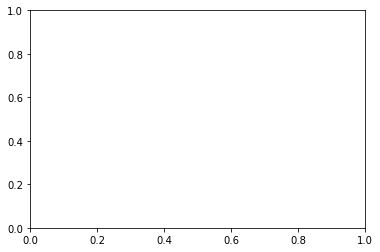

In [94]:
plt.plot(t_gone, val_m)
plt.title('Watts-Strogatz, mean magnetization of 100 runs')
plt.grid();

# 5th dot